In [2]:
import torch
from torchvision import models
import torch.nn as nn

model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')

blocks_to_keep = None

# Modify the internal features blocks keeping "blocks_to_kep"
if blocks_to_keep is not None:
    # We extract the original blocks and reconstruct the features
    all_blocks = list(model.features.children())
    model.features = nn.Sequential(*[all_blocks[i] for i in blocks_to_keep])
    
    # Recalculate the classifier input because removing blocks changes the depth
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 224, 224)
        new_in_channels = model.features(dummy_input).shape[1]
        out_features = model.classifier[0].out_features
    
    # Modify the classifier head
    model.classifier[0] = nn.Linear(new_in_channels, out_features)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 8)  

print(f"{'Index':<5} | {'Layer Type':<25} | {'Stride'} | {'Output Channels'}")
print("-" * 70)

for i, block in enumerate(model.features.children()):
    stride = 1
    # We look for the Conv2d layer within the block that has stride > 1
    for module in block.modules():
        if isinstance(module, nn.Conv2d):
            if module.stride[0] > 1:
                stride = module.stride[0]
                break
    
    # Get the output channels of the block
    # We use a dummy forward to be 100% sure of the dimensions
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 224, 224)
        # Apply layers up to this block
        out = model.features[:i+1](dummy_input)
        out_channels = out.shape[1]

    print(f"{i:<5} | {type(block).__name__:<25} | {stride:<6} | {out_channels}")
    
# Also print the classifier structure for reference
print("\n" + "="*30)
print("CLASSIFIER STRUCTURE")
print("="*30)
print(model.classifier)

Index | Layer Type                | Stride | Output Channels
----------------------------------------------------------------------
0     | Conv2dNormActivation      | 2      | 16
1     | InvertedResidual          | 1      | 16
2     | InvertedResidual          | 2      | 24
3     | InvertedResidual          | 1      | 24
4     | InvertedResidual          | 2      | 40
5     | InvertedResidual          | 1      | 40
6     | InvertedResidual          | 1      | 40
7     | InvertedResidual          | 2      | 80
8     | InvertedResidual          | 1      | 80
9     | InvertedResidual          | 1      | 80
10    | InvertedResidual          | 1      | 80
11    | InvertedResidual          | 1      | 112
12    | InvertedResidual          | 1      | 112
13    | InvertedResidual          | 2      | 160
14    | InvertedResidual          | 1      | 160
15    | InvertedResidual          | 1      | 160
16    | Conv2dNormActivation      | 1      | 960

CLASSIFIER STRUCTURE
Sequential(
  (0): Linea

Informative image saved as mobilenet_architecture_analysis.png


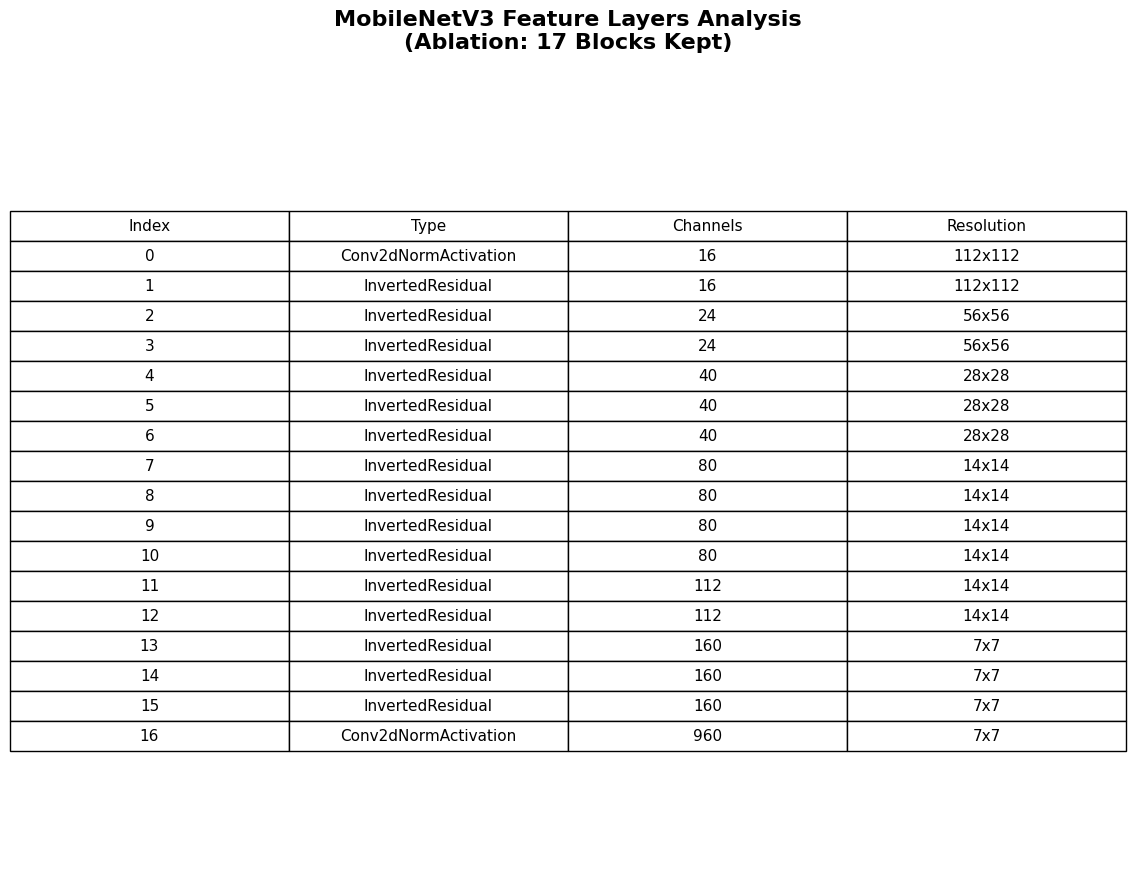

In [3]:
import torch
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# 1. Setup Model (Original or Truncated)
model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
blocks_to_keep = None # Example: Truncating at block 12

if blocks_to_keep is not None:
    all_blocks = list(model.features.children())
    model.features = nn.Sequential(*[all_blocks[i] for i in blocks_to_keep])

# 2. Extract Data for Plotting
data = []
for i, block in enumerate(model.features.children()):
    stride = 1
    for module in block.modules():
        if isinstance(module, nn.Conv2d):
            if module.stride[0] > 1:
                stride = module.stride[0]
                break
    
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 224, 224)
        out = model.features[:i+1](dummy_input)
        out_channels = out.shape[1]
        spatial_res = out.shape[2] # H/W dimension

    data.append({
        "Index": i,
        "Type": type(block).__name__,
        #"Stride": stride,
        "Channels": out_channels,
        "Resolution": f"{spatial_res}x{spatial_res}"
    })

df = pd.DataFrame(data)

# 3. Create the Visualization
fig, ax = plt.subplots(figsize=(12, len(df)*0.5 + 2))
ax.axis('off')

# Color coding for blocks: Stride 2 blocks often mark 'Stage' transitions
#colors = [['#f2f2f2' if s == 1 else '#d1e7dd' for s in df['Stride']]] * len(df.columns)

table = ax.table(cellText=df.values, 
                 colLabels=df.columns, 
                 #cellColours=list(zip(*colors)),
                 loc='center', 
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

plt.title(f"MobileNetV3 Feature Layers Analysis\n(Ablation: {len(df)} Blocks Kept)", 
          fontsize=16, fontweight='bold', pad=20)

plt.savefig("mobilenet_architecture_analysis.png", bbox_inches='tight', dpi=300)
print("Informative image saved as mobilenet_architecture_analysis.png")

In [4]:
import torch
import torch.nn as nn
from torchvision import models

def count_parameters(model):
    """Calcula el total de parámetros entrenables y no entrenables."""
    return sum(p.numel() for p in model.parameters())

# 1. MODELO ORIGINAL (ImageNet - 1000 clases)
model_orig = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
print(f"1. Modelo Original (1000 clases): {count_parameters(model_orig) / 1e6:.2f}M")

# 2. TU MODELO ADAPTADO (8 clases)
# Aquí es donde bajamos de 5.48M a ~4.2M al cambiar la última capa
model_8 = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
model_8.classifier[-1] = nn.Linear(model_8.classifier[-1].in_features, 8)
print(f"2. Tu Modelo Adaptado (8 clases): {count_parameters(model_8) / 1e6:.2f}M")

# 3. VERIFICACIÓN DE ABLACIÓN (Quitando bloques del final)
def check_ablation(n_blocks_removed):
    model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
    all_blocks = list(model.features.children())
    
    # Truncamos las features
    model.features = nn.Sequential(*all_blocks[:len(all_blocks) - n_blocks_removed])
    
    # Recalculamos la entrada del clasificador dinámicamente
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 224, 224)
        new_in_channels = model.features(dummy_input).shape[1]
    
    # Reconstruimos la cabeza para 8 clases
    out_features = model.classifier[0].out_features
    model.classifier[0] = nn.Linear(new_in_channels, out_features)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 8)
    
    return count_parameters(model)

print("-" * 40)
for i in range(1, 5):
    p = check_ablation(i)
    print(f"Ablación: -{i} bloques | Parámetros: {p / 1e6:.2f}M")

1. Modelo Original (1000 clases): 5.48M
2. Tu Modelo Adaptado (8 clases): 4.21M
----------------------------------------
Ablación: -1 bloques | Parámetros: 3.03M
Ablación: -2 bloques | Parámetros: 2.24M
Ablación: -3 bloques | Parámetros: 1.44M
Ablación: -4 bloques | Parámetros: 0.95M


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [6]:
def plot_accuracy_boxplots(data, title="Spatial Pyramid Matching Performance", 
                           x_text="", x_axis_label = 'Pyramid Level ($L$)', 
                           y_axis_label = 'Accuracy (%)', 
                           y_dim = [25, 45], bp_width=0.3):
    
    # 1. Extracción de datos
    data_content = data['Data']
    raw_keys = list(data_content['Accuracy'].keys())
    accuracy_data = [data_content['Accuracy'][k] for k in raw_keys]
    levels_numeric = list(range(len(raw_keys)))
    
    # 2. Configuración del gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    color_acc = '#1f77b4' # Azul profesional
    
    # Dibujar Boxplots
    bp = ax.boxplot(accuracy_data, 
                    positions=levels_numeric, 
                    widths=bp_width,
                    patch_artist=True,
                    boxprops=dict(facecolor=color_acc, color='black', alpha=0.6),
                    capprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    medianprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))
    
    # --- Formateo de Ejes (Aumento de tamaño solicitado) ---
    ax.set_xlabel(x_axis_label, fontsize=16, labelpad=10)
    ax.set_ylabel(y_axis_label, fontsize=16, labelpad=10)
    
    # Aumentamos el tamaño de los números en los ejes (ticks)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Límites del eje Y
    ax.set_ylim(y_dim[0], y_dim[1])
    
    # Etiquetas del eje X
    ax.set_xticks(levels_numeric)
    x_labels = [f"{x_text}{l}" for l in raw_keys]
    ax.set_xticklabels(x_labels) 
    
    # --- Título y Estilo ---
    ax.set_title(title, fontsize=18, fontweight='bold', pad=15)
    
    # Rejilla y estética
    ax.grid(True, linestyle='--', alpha=0.6, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_spatial_pyramids_boxplots(data, title="Spatial Pyramid Matching Performance", 
                                x_text="Level", x_axis_label = 'Pyramid Level ($L$)', 
                                y_axis_label_1 = 'Accuracy (%)', y_axis_label_2='Run Time (minutes)', 
                                y1_dim = [25, 45], bp_width=0.3, y2_dim = [0, 10]):

    
    # 1. Data Extraction (ADAPTED for Fisher Vectors/N components)
    data_content = data['Data']
    
    # Get the raw keys (e.g., 'K-Means', 5, 10, 25, 40)
    raw_keys = list(data_content['Accuracy'].keys())
    
    # Extract Accuracy values (lists of results for each key)
    accuracy_data = [data_content['Accuracy'][k] for k in raw_keys]
    
    # Extract Runtime values. Values are assumed to be scalars for each key.
    runtimes = [data_content['Runtime'][k] for k in raw_keys]

    # Create numerical positions (0, 1, 2, ...) for the X-axis
    levels_numeric = list(range(len(raw_keys)))
    
    # 2. Setup Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # --- LEFT Y-AXIS: ACCURACY (BOXPLOTS) ---
    color_acc = '#1f77b4' # Professional Blue
    
    # Draw Boxplots. Use numerical positions for correct placement.
    bp = ax1.boxplot(accuracy_data, 
                     positions=levels_numeric, 
                     widths=bp_width,
                     patch_artist=True, # Allows filling the boxes with color
                     boxprops=dict(facecolor=color_acc, color='black', alpha=0.6),
                     capprops=dict(color='black'),
                     whiskerprops=dict(color='black'),
                     medianprops=dict(color='black', linewidth=1.5),
                     flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))
    
    # Axis Formatting
    ax1.set_xlabel(x_axis_label, fontsize=14, labelpad=10)
    ax1.set_ylabel(y_axis_label_1, fontsize=14, color=color_acc, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color_acc)
    
    # Set the specific limits you requested
    ax1.set_ylim(y1_dim[0], y1_dim[1])
    
    # Set X-axis tick positions to the numerical indices
    ax1.set_xticks(levels_numeric)
    
    # Create customized X-axis labels: 'K-Means' is direct, numbers are prefixed by x_text (e.g., 'N 5')
    x_labels = [f"{x_text}{l}" for l in raw_keys]
    ax1.set_xticklabels(x_labels) 
    
    # --- RIGHT Y-AXIS: RUNTIME (LINE) ---
    # Create a second axes object that shares the same x-axis (twinx)
    ax2 = ax1.twinx()
    color_time = '#d62728' # Professional Red
    
    # Plot Time Line. Use numerical positions for correct alignment.
    line2, = ax2.plot(levels_numeric, runtimes, marker='s', linestyle='--', 
                      linewidth=2, color=color_time, label='Run Time')
    
    # Axis Formatting for Time
    ax2.set_ylabel(y_axis_label_2, fontsize=14, color=color_time, labelpad=10)
    ax2.tick_params(axis='y', labelcolor=color_time)
    
    # Adjust the upper limit for the runtime axis dynamically
    ax2.set_ylim(y2_dim[0], y2_dim[1])
    
    # --- LEGEND & STYLING ---
    # Create a custom proxy artist for the boxplot to show in the legend
    patch_acc = mpatches.Patch(color=color_acc, label='Accuracy Distribution')
    
    # Combine the legends for both plots (boxplot proxy and line plot)
    lines = [patch_acc, line2]
    labels = [l.get_label() for l in lines]
    
    ax1.legend(lines, labels, loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=15)
    
    # Clean up appearance
    ax1.grid(True, linestyle='--', alpha=0.6, axis='y')
    ax1.spines['top'].set_visible(False) # Hide the top spine for a cleaner look
    
    plt.tight_layout()
    plt.show()

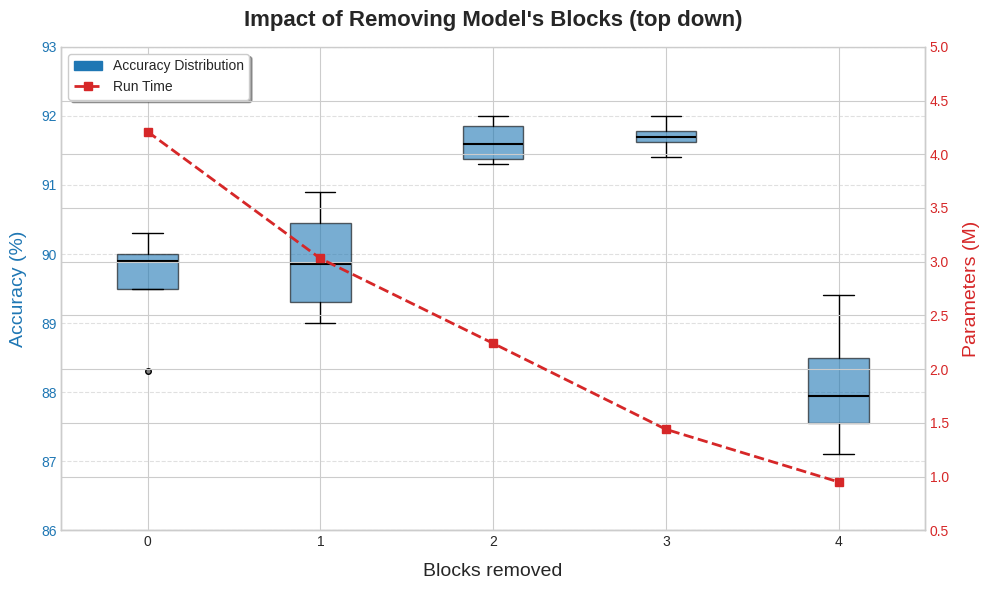

In [ ]:
performance_image_size = {
    'Data':{
        'Accuracy':{
            '0': [88.3, 89.9, 89.9, 90.3],
            '1': [89.0, 89.4, 90.3, 90.9],
            '2': [91.4, 91.3, 91.8, 92.0],
            '3': [91.7, 92.0, 91.7, 91.4],
            '4': [89.4, 87.1, 87.7, 88.2]
        },
        'Runtime': {
            '0': 4.21,
            '1': 3.03,
            '2': 2.24,
            '3': 1.44,
            '4': 0.95
        }
    }
}

plot_spatial_pyramids_boxplots(performance_image_size, title="Impact of Removing Model's Blocks (top down)", 
                               y1_dim=[86,94], y2_dim=[0.5,5], x_text="", x_axis_label="Blocks removed", bp_width=0.35,
                               y_axis_label_2="Parameters (M)")